In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import math
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from Caulimate.Data.CESM2.dataset import CESM2_grouped_dataset, downscale_dataset
from Caulimate.Utils.Visualization import quick_map
from Caulimate.Utils.Metrics import MAE, MSE, MAPE, RMSE, R_squared
from Caulimate.Utils.Tools import makedir, check_tensor, seed_everything

seed_everything(42)

In [2]:
DATA_DIR = '/l/users/minghao.fu/minghao.fu/dataset/CESM2' # you could modify it to your path
DOWNSCALE_PATH = os.path.join(DATA_DIR, 'downscaled_pacific_CESM2.txt')
DOWNSCALE_METADATA_PATH = os.path.join(DATA_DIR, 'downscaled_metadata.pkl')

NUM_AREA = 1
TIME_IDX = 1000
SAVE_DIR = './Figures'

makedir(SAVE_DIR)
dataset = downscale_dataset(DOWNSCALE_PATH, DOWNSCALE_METADATA_PATH)

In [3]:
data = dataset.X  # Random data for example

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Create dataset (t-1, t)
def create_dataset(data):
    X, y = [], []
    for i in range(1, len(data)):
        X.append(data[i-1])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_dataset(data)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [4]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead, nlayers):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.input_embedding = nn.Linear(input_size, hidden_size)
        self.positional_encoding = nn.Parameter(torch.rand(1, hidden_size))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(hidden_size, nhead), nlayers)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_embedding(x) * math.sqrt(self.hidden_size)
        x = x + self.positional_encoding
        x = self.transformer(x)
        x = self.output(x)
        return x

In [12]:
input_size = X_train.shape[1]  # Should be equal to dim
hidden_size = 16
output_size = y_train.shape[1]  # Should be equal to dim
extent = [-140, -70, -10, 10]
vmin = -2
vmax = 2
cmap = plt.cm.RdBu_r
IMAGE_IDX = 0

y_lst = []
predicted_lst = []
diff_xr_lst = []

for model in [MLP(input_size, hidden_size, output_size), nn.Linear(input_size, output_size), MLP(input_size, hidden_size // 2, output_size)]:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    epochs = 10000
    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % (epochs // 2) == 0:
            print(f'Epoch [{epoch+1}/{epochs}], MSE Loss: {loss.item():.4f}')

    model.eval()

    # Calculate training loss
    train_outputs = model(X_train)
    train_loss = criterion(train_outputs, y_train).item()

    # Calculate test loss
    test_outputs = model(X_test)

    train_predict = model(X_train).detach().numpy()
    test_predict = model(X_test).detach().numpy()

    test_predict = scaler.inverse_transform(test_predict)
    y_test_recover = scaler.inverse_transform(y_test.numpy())

    test_mae = MAE(test_predict, y_test_recover) 
    test_mape = MAPE(test_predict, y_test_recover)
    test_R_squared = R_squared(test_predict, y_test_recover)
    test_rmse = RMSE(test_predict, y_test_recover)

    #print(f'--- [Training Loss] RMSE: {np.sqrt(train_loss):.4f}')
    print(f'--- [Test Loss] MAE: {test_mae:.4f} | MAPE: {test_mape:.4f} | R^2: {test_R_squared:.4f} | RMSE: {test_rmse:.4f}')

    predicted_lst.append(test_predict)
    y_lst.append(y_test_recover)
    # diff_xr_lst.append(forecast_xr - y_xr)

    # forecast_xr = dataset.area_xr_da.isel(time=TIME_IDX + 1).copy()
    # for i, group_ind in enumerate(dataset.group_inds):
    #     forecast_xr.values = np.where(dataset.area_xr_da.group_index == group_ind, forecast_temperature[i], forecast_xr.values)
    # y_xr = dataset.area_xr_da.isel(time=TIME_IDX + 1).copy()
    # y_temperature = y_test_recover[TIME_IDX + 1]
    # for i, group_ind in enumerate(dataset.group_inds):
    #     y_xr.values = np.where(dataset.area_xr_da.group_index == group_ind, y_temperature[i], y_xr.values)
    # diff_xr_lst.append(forecast_xr - y_xr)

Epoch [5000/10000], MSE Loss: 0.0035
Epoch [10000/10000], MSE Loss: 0.0034
--- [Test Loss] MAE: 0.2376 | MAPE: 1.4248 | R^2: 0.8963 | RMSE: 0.3086
Epoch [5000/10000], MSE Loss: 0.0021
Epoch [10000/10000], MSE Loss: 0.0019
--- [Test Loss] MAE: 0.1739 | MAPE: 1.4878 | R^2: 0.9456 | RMSE: 0.2290
Epoch [5000/10000], MSE Loss: 0.0048
Epoch [10000/10000], MSE Loss: 0.0049
--- [Test Loss] MAE: 0.2874 | MAPE: 2.2580 | R^2: 0.8383 | RMSE: 0.3770


In [6]:
IMAGE_IDX = 0 
for _, _, diff_xr in zip(predicted_lst, y_lst, diff_xr_lst):
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude')
    ax.set_title('Sea Surface Temperature (SST)')
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable labels at the top
    gl.right_labels = False  # Disable labels on the right
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    cbar_kwargs = {
        'fraction': 0.0135,  # Adjust as needed
        'pad': 0.04,  # Adjust as needed
    }
    # ax.set_extent(extent)
    diff_xr.plot(x='lon', y='lat', transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.tight_layout()
    plt.savefig(f'./Figures/CESM2ForecastDiff{IMAGE_IDX}.pdf', bbox_inches='tight', dpi=300, format='pdf')  
    IMAGE_IDX += 1

IndexError: index 4 is out of bounds for axis 0 with size 4

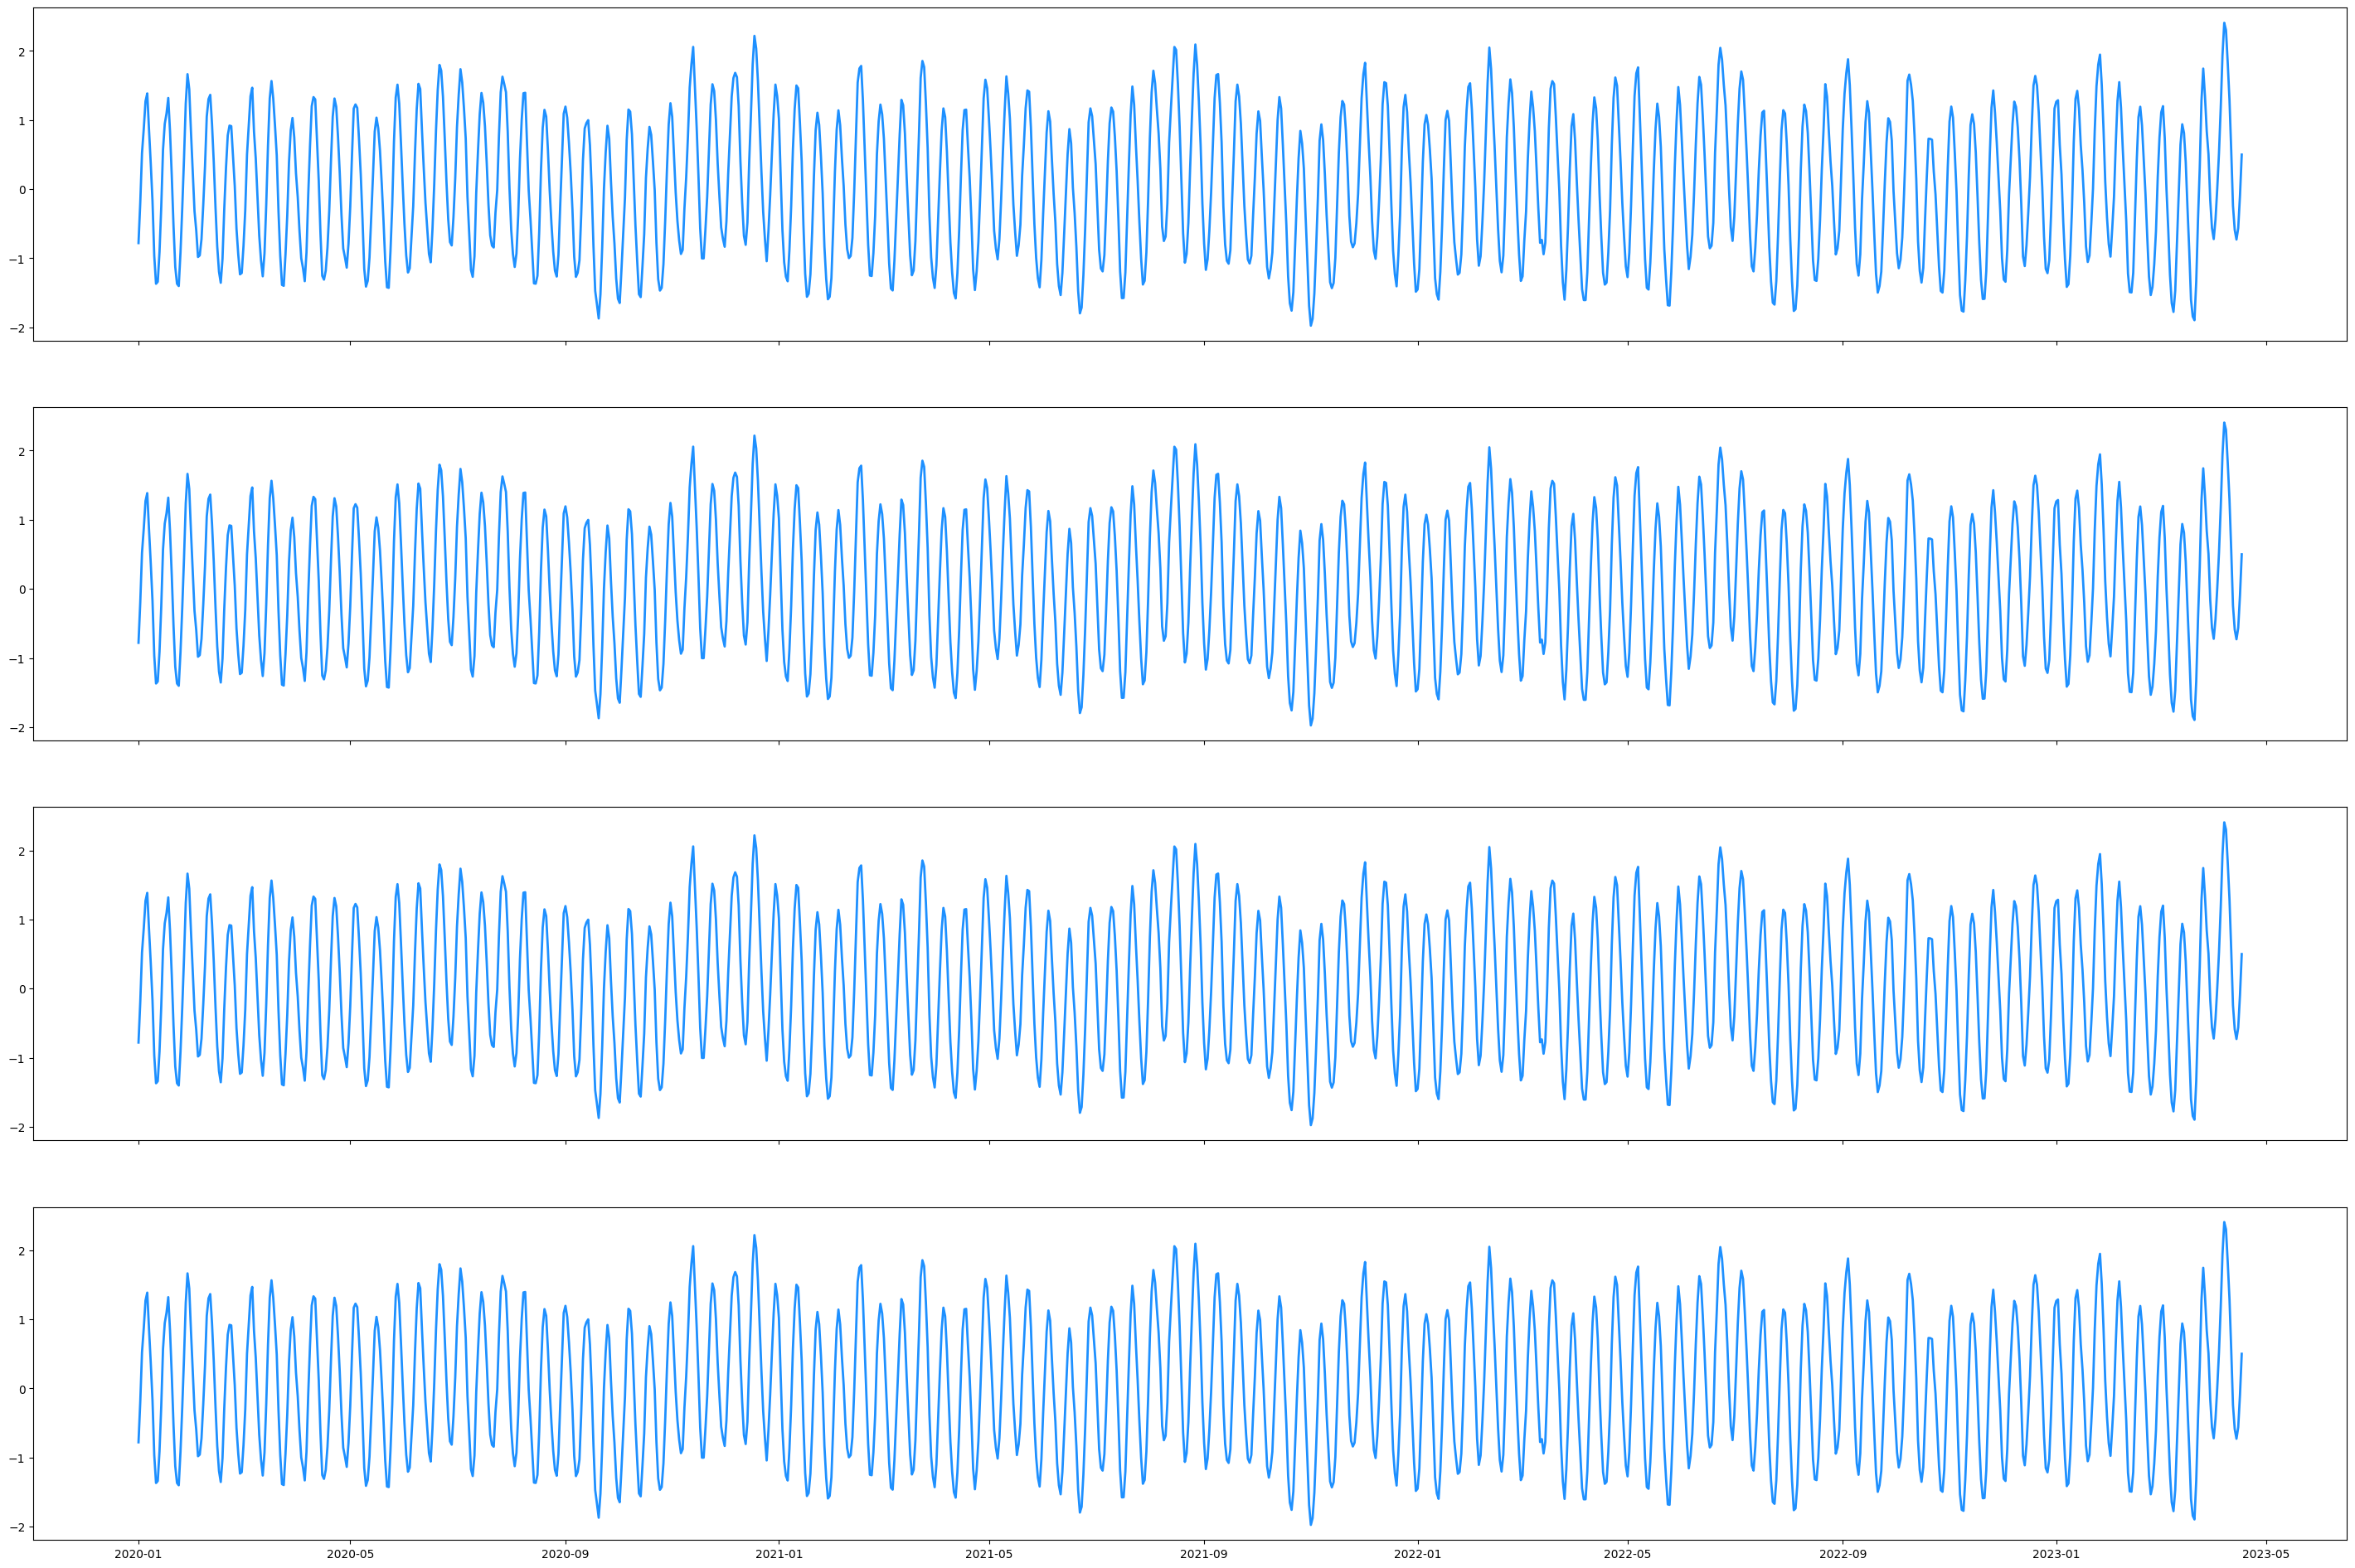

In [8]:
font_size=28
label_lst = ['(a) Ground Truth', '(b) TV-GOLEM Prediction', '(c) ISSM Prediction', '(d) GPDCM Prediction']
color_lst = ['dodgerblue', 'darkorange', 'forestgreen', 'firebrick']
center_ids = [11, 80]
fig, axs = plt.subplots(4, 1, figsize=(36, 24), sharex=True)

for i, center_idx in enumerate(center_ids):
    np.random.seed(0)
    data_gt = y_lst[0][:, center_idx]
    date_range = pd.date_range(start='2020-01-01', periods=len(data_gt), freq='D')
    
    for i in range(len(predicted_lst)):
        axs[i].plot(date_range, data_gt, label=label_lst[i], color=color_lst[i], linewidth=2, linestyle='-')
    
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].legend(fontsize=font_size)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_xlabel('Date', fontsize=font_size)

    for i in range(len(axs)):
        
        axs[i].set_ylabel('Temperature (˚C)', fontsize=font_size)

        # Adding a grid
        axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)

        # Adding a legend
        axs[i].legend(fontsize=12)

        # Rotate date labels for better readability
        axs[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('./Figures/CESM2Forecast{}.pdf'.format(center_idx), bbox_inches='tight', dpi=300, format='pdf')  
    plt.show()

In [10]:
len(predicted_lst)

6

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

# Define your models (example MLP model)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Load your data
# X_train and X_test should be loaded or defined here
# Example: X_train, X_test = load_data()

# Define parameters
input_size = X_train.shape[1]  # Should be equal to dim
hidden_size = 50
output_size = X_train.shape[1]  # Predict the next sequence step
seq_length = 10  # Define the sequence length for multi-step forecasting

# Prepare the data for multi-step forecasting
X_train_seq, y_train_seq = create_sequences(X_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, seq_length)

# Ensure the data is in the right shape
X_train_seq = X_train_seq.reshape(-1, seq_length * input_size)
y_train_seq = y_train_seq.reshape(-1, input_size)
X_test_seq = X_test_seq.reshape(-1, seq_length * input_size)
y_test_seq = y_test_seq.reshape(-1, input_size)

# Scale the data if necessary
scaler = MinMaxScaler()
y_train_seq = scaler.fit_transform(y_train_seq)
y_test_seq = scaler.transform(y_test_seq)

# Metrics functions
def MAPE(pred, actual):
    return np.mean(np.abs((actual - pred) / actual)) * 100

def R_squared(pred, actual):
    ss_res = np.sum((actual - pred) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    return 1 - (ss_res / ss_tot)

def RMSE(pred, actual):
    return np.sqrt(MSE(actual, pred))

# Training loop
def train_model(model, X_train_seq, y_train_seq, epochs=10000, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        
        # Convert inputs and targets to tensors
        inputs = torch.tensor(X_train_seq, dtype=torch.float32)
        targets = torch.tensor(y_train_seq, dtype=torch.float32)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % (epochs // 2) == 0:
            print(f'Epoch [{epoch+1}/{epochs}], MSE Loss: {loss.item():.4f}')

# Autoregressive forecasting function
def autoregressive_forecast(model, initial_seq, n_steps, scaler):
    model.eval()
    forecast = []
    current_seq = initial_seq.copy()

    for _ in range(n_steps):
        input_seq = torch.tensor(current_seq.reshape(1, -1), dtype=torch.float32)
        with torch.no_grad():
            pred = model(input_seq).numpy()
        forecast.append(pred)
        current_seq = np.roll(current_seq, -input_size)
        current_seq[-input_size:] = pred

    forecast = np.array(forecast).reshape(-1, input_size)
    forecast = scaler.inverse_transform(forecast)
    return forecast

y_lst = []
predicted_lst = []

models = [MLP(seq_length * input_size, hidden_size, output_size), 
          nn.Linear(seq_length * input_size, output_size), 
          MLP(seq_length * input_size, hidden_size // 2, output_size)]

for model in models:
    train_model(model, X_train_seq, y_train_seq)

    initial_seq = X_test_seq[0]  # Starting sequence for autoregressive prediction
    n_steps = len(X_test_seq)  # Number of steps to forecast

    forecast = autoregressive_forecast(model, initial_seq, n_steps, scaler)
    y_test_recover = scaler.inverse_transform(y_test_seq)
    
    test_mae = MAE(forecast, y_test_recover)
    test_mape = MAPE(forecast, y_test_recover)
    test_R_squared = R_squared(forecast, y_test_recover)
    test_rmse = RMSE(forecast, y_test_recover)

    print(f'--- [Test Loss] MAE: {test_mae:.4f} | MAPE: {test_mape:.4f} | R^2: {test_R_squared:.4f} | RMSE: {test_rmse:.4f}')

    predicted_lst.append(forecast)
    y_lst.append(y_test_recover)


Epoch [5000/10000], MSE Loss: 0.0430
Epoch [10000/10000], MSE Loss: 0.0430
--- [Test Loss] MAE: 0.1753 | MAPE: inf | R^2: 0.0580 | RMSE: 0.2071


/tmp/ipykernel_1406672/2887311564.py:60: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((actual - pred) / actual)) * 100


Epoch [5000/10000], MSE Loss: 0.0264
Epoch [10000/10000], MSE Loss: 0.0115
--- [Test Loss] MAE: 13.3849 | MAPE: inf | R^2: -10558.0664 | RMSE: 21.9263


/tmp/ipykernel_1406672/2887311564.py:60: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((actual - pred) / actual)) * 100


Epoch [5000/10000], MSE Loss: 0.0430
Epoch [10000/10000], MSE Loss: 0.0430
--- [Test Loss] MAE: 0.1753 | MAPE: inf | R^2: 0.0580 | RMSE: 0.2071


/tmp/ipykernel_1406672/2887311564.py:60: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((actual - pred) / actual)) * 100


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define your models (example MLP model)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]  # Should be equal to dim
hidden_size = 50
output_size = X_train.shape[1]  # Predict the next sequence step
seq_length = 10  # Define the sequence length for multi-step forecasting

# Prepare the data for multi-step forecasting
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, seq_length)

# Ensure the data is in the right shape
X_train_seq = X_train_seq.reshape(-1, seq_length * input_size)
y_train_seq = y_train_seq.reshape(-1, input_size)
X_test_seq = X_test_seq.reshape(-1, seq_length * input_size)
y_test_seq = y_test_seq.reshape(-1, input_size)

y_lst = []
predicted_lst = []

for model in [MLP(seq_length * input_size, hidden_size, output_size), nn.Linear(seq_length * input_size, output_size), MLP(seq_length * input_size, hidden_size // 2, output_size)]:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    epochs = 10000
    for epoch in range(epochs):
        model.train()
        
        # Convert inputs and targets to tensors
        inputs = torch.tensor(X_train_seq, dtype=torch.float32)
        targets = torch.tensor(y_train_seq, dtype=torch.float32)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % (epochs // 2) == 0:
            print(f'Epoch [{epoch+1}/{epochs}], MSE Loss: {loss.item():.4f}')

    model.eval()

    # Calculate training loss
    train_outputs = model(torch.tensor(X_train_seq, dtype=torch.float32))
    train_loss = criterion(train_outputs, torch.tensor(y_train_seq, dtype=torch.float32)).item()

    # Calculate test loss
    test_outputs = model(torch.tensor(X_test_seq, dtype=torch.float32))

    train_predict = model(torch.tensor(X_train_seq, dtype=torch.float32)).detach().numpy()
    test_predict = model(torch.tensor(X_test_seq, dtype=torch.float32)).detach().numpy()

    # Inverse transform the predictions if necessary
    # train_predict = scaler.inverse_transform(train_predict)
    # y_train_seq = scaler.inverse_transform(y_train_seq)
    test_predict = scaler.inverse_transform(test_predict)
    y_test_recover = scaler.inverse_transform(y_test_seq)

    test_mae = MAE(test_predict, y_test_recover) 
    test_mape = MAPE(test_predict, y_test_recover)
    test_R_squared = R_squared(test_predict, y_test_recover)
    test_rmse = RMSE(test_predict, y_test_recover)

    print(f'--- [Test Loss] MAE: {test_mae:.4f} | MAPE: {test_mape:.4f} | R^2: {test_R_squared:.4f} | RMSE: {test_rmse:.4f}')

    predicted_lst.append(test_predict)
    y_lst.append(y_test_recover)

# Optionally forecast future steps if required
# future_forecast = model(torch.tensor(next_input, dtype=torch.float32)).detach().numpy()


Epoch [5000/10000], MSE Loss: 0.0107


Epoch [10000/10000], MSE Loss: 0.0107
--- [Test Loss] MAE: 0.0817 | MAPE: 22.7912 | R^2: 0.7494 | RMSE: 0.1061
Epoch [5000/10000], MSE Loss: 0.0031
Epoch [10000/10000], MSE Loss: 0.0131
--- [Test Loss] MAE: 0.0583 | MAPE: 14.7114 | R^2: 0.6588 | RMSE: 0.1238
Epoch [5000/10000], MSE Loss: 0.0107
Epoch [10000/10000], MSE Loss: 0.0107
--- [Test Loss] MAE: 0.0817 | MAPE: 22.7949 | R^2: 0.7494 | RMSE: 0.1061


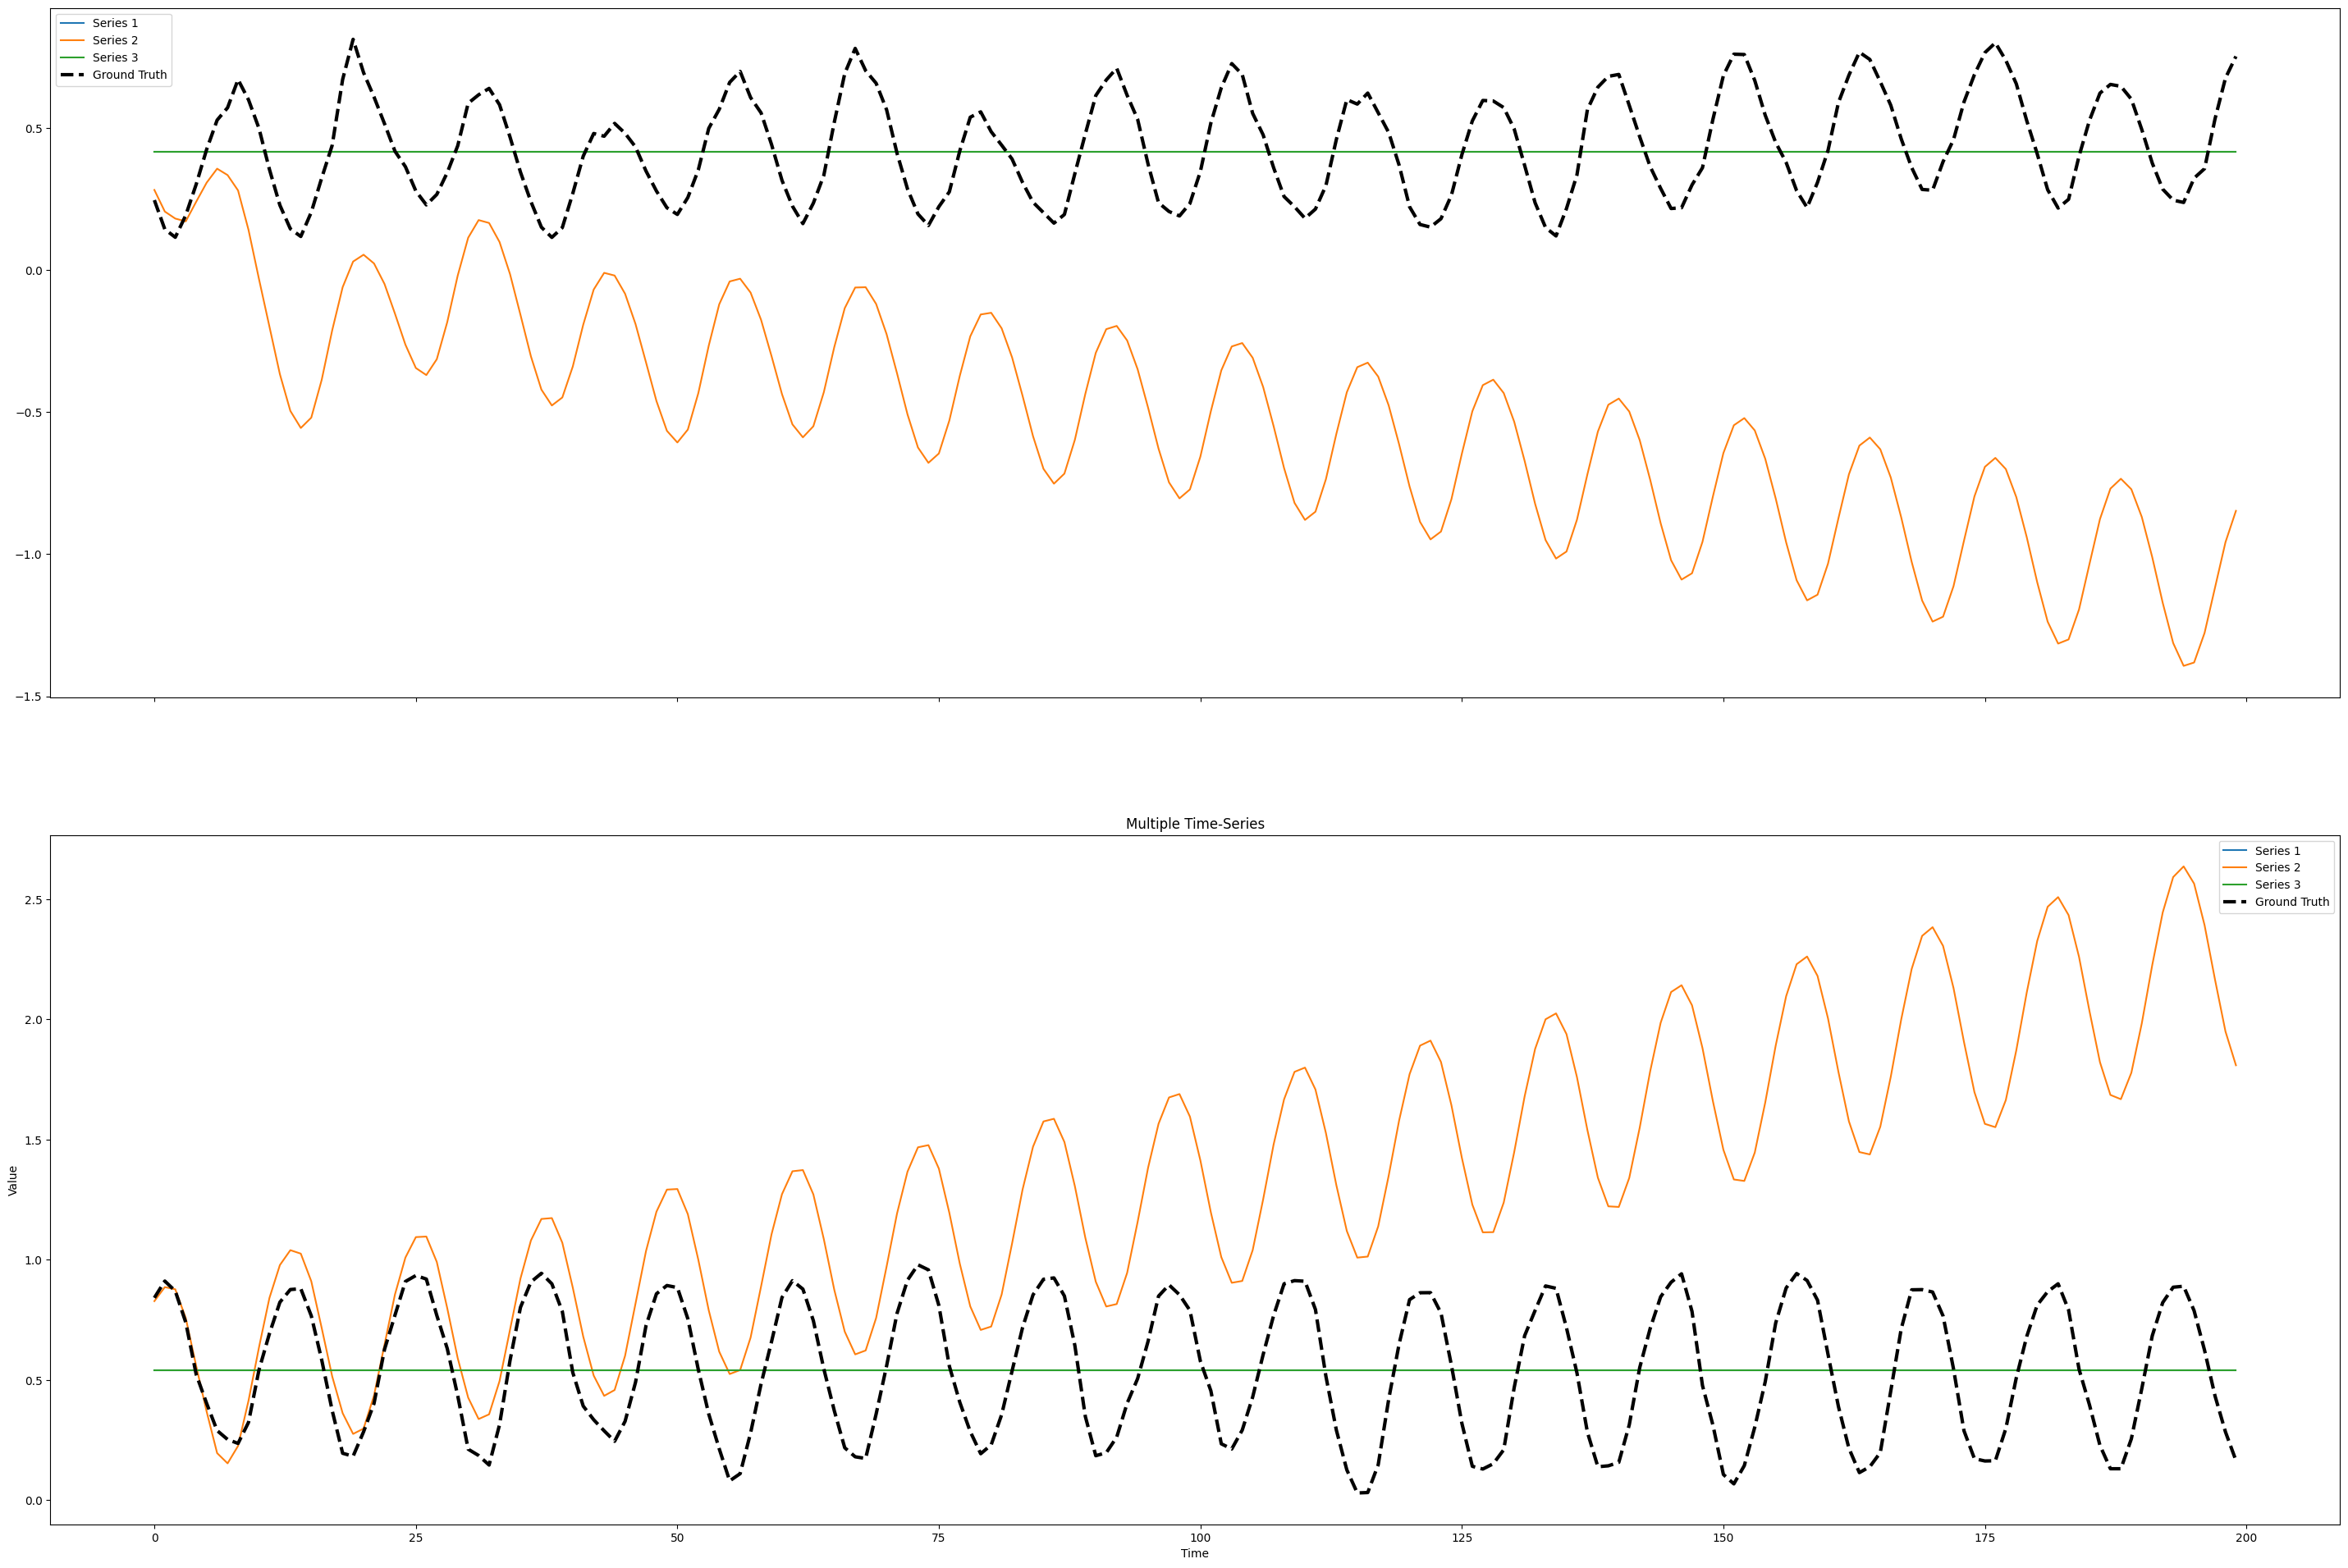

In [ ]:
n_times = 200
center_ids = [10, 80]
fig, axs = plt.subplots(len(center_ids), 1, figsize=(36, 24), sharex=True)
for i, center_idx in enumerate(center_ids): 
    for j, ts in enumerate(predicted_lst):
        axs[i].plot(ts[:n_times, center_idx], label=f'Series {j+1}')
    axs[i].plot(y_lst[0][:n_times, center_idx], label='Ground Truth', color='black', linestyle='--', lw=3)
    axs[i].legend()
axs[i].set_title('Multiple Time-Series')
axs[i].set_xlabel('Time')
axs[i].set_ylabel('Value')
plt.show()

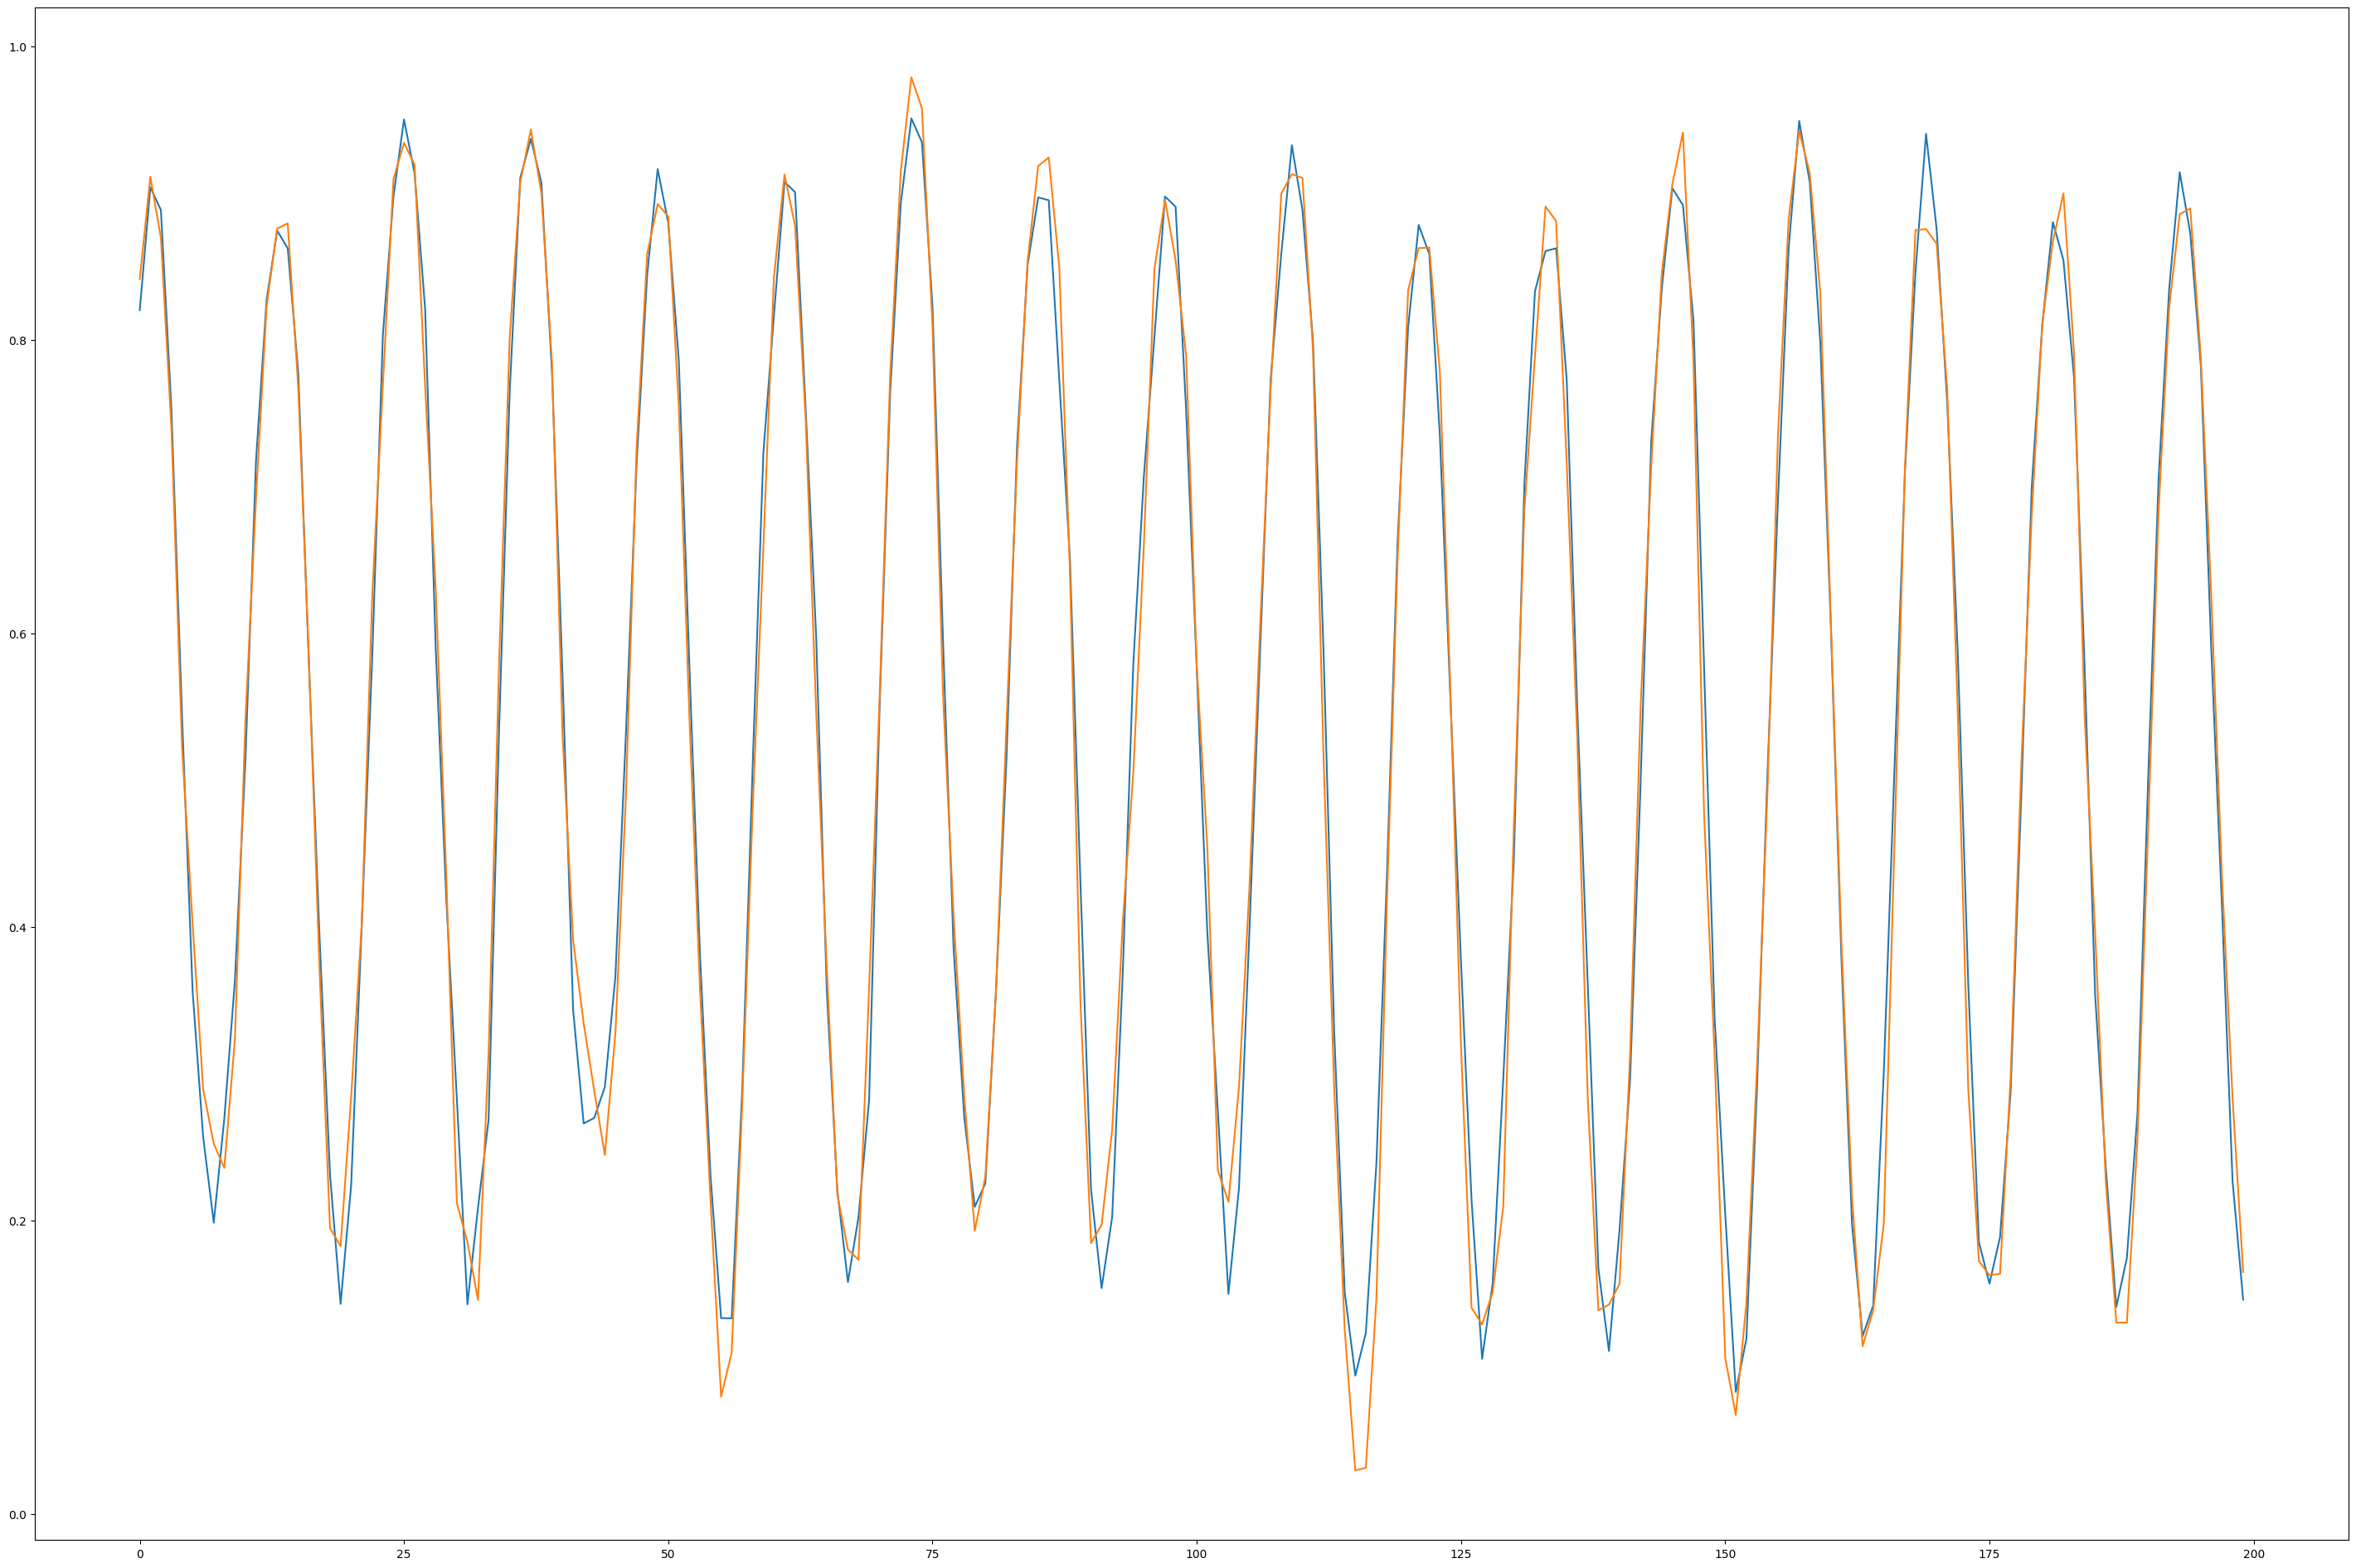

In [ ]:
fig, ax = plt.subplots(figsize=(36, 24), sharex=True)
ax.plot(predicted_lst[1][:n_times, center_idx], label=f'Series {j+1}')
ax.plot(y_lst[1][:n_times, center_idx], label=f'Series {j+1}')